In [2]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
from pymorphy2.tagset import OpencorporaTag
from params import NO_PUNCT, build_params
import torch
import torch.nn as nn

feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
    ['PUNCT_DASH', 'PUNCT_DOT', 'PUNCT_COMMA', 'PUNCT_QUOTE',
     'PUNCT_LEFT_PARENTHESIS', 'PUNCT_RIGHT_PARENTHESIS' ], # "()
    ['CAPITALIZED'], # начинается с заглавной буквы
    ['Fixd', 'Abbr'] # неизменяемое, сокращение
]

CUT_NAVEC_TAGS_ARRAY = [
    #'NOUN', #'ADJF'
]

params = build_params({
    "VARIANTS_CNT": 1,
    "TARGET_CLASSES_COUNT": 3,
    "INPUT_WORDS_CNT": 16,
    "feature_tags_array": feature_tags_array,
    "PUNCTUATION_TARGET": {
        "$empty": NO_PUNCT,
        ",": 1,
        ".": 2,
        "!": 2,
        "?": 2,
    },
    "USE_NAVEC": True,
    'CUT_NAVEC_TAGS_SET': set(CUT_NAVEC_TAGS_ARRAY),
    'INFECTED_TEXT_PROB': 0.1,
    "RETAIN_LEFT_PUNCT": True,
})

N_words = params["INPUT_WORDS_CNT"]
# N_variants = params["VARIANTS_CNT"]
N_features = params["TOTAL_WORD_FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 64

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  #sine
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0.,
        "attention": {
            "name": "scaled_dot_product", #linformer scaled_dot_product fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0., # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0.,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}

class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        # N_variants = params['VARIANTS_CNT']
        N_features = params['TOTAL_WORD_FEATURES_CNT']

        # input is (N, N_words, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            # nn.Flatten(2), 
            # (N, N_words, N_features + )
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_features, INTERNAL_EMBEDDING_SIZE),
            nn.BatchNorm1d(N_words),
            nn.ReLU(),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2

model = torch.load("model.v1", map_location=torch.device('cpu'))
model

Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


Model(
  (model): Sequential(
    (0): Linear(in_features=363, out_features=64, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): xFormerEncoderBlock(
      (pose_encoding): SinePositionalEmbedding()
      (wrap_att): Residual(
        (layer): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (sublayer): MultiHeadDispatch(
            (attention): ScaledDotProduct(
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (in_proj_container): InputProjection(
              (q_proj): Linear(in_features=64, out_features=64, bias=True)
              (k_proj): Linear(in_features=64, out_features=64, bias=True)
              (v_proj): Linear(in_features=64, out_features=64, bias=True)
            )
            (resid_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
      )

In [2]:
params['TOTAL_WORD_FEATURES_CNT']

363

In [3]:
dummy_input = torch.ones((1, params['INPUT_WORDS_CNT'], params['TOTAL_WORD_FEATURES_CNT']))
with torch.no_grad():
        print(model(dummy_input))
        # torch.onnx.export(model, dummy_input, "model.v1.onnx", verbose=True)

tensor([[-2.1201,  2.5673, -0.3095]])


In [106]:
torch_script_graph, unconvertible_ops = torch.onnx.utils.unconvertible_ops(
    model, dummy_input #, opset_version=opset_version
)


/home/misha-sh/.local/lib/python3.10/site-packages/xformers/components/multi_head_dispatch.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if query.shape[0] != key.shape[0] or query.shape[0] != value.shape[0]:
/home/misha-sh/.local/lib/python3.10/site-packages/xformers/components/multi_head_dispatch.py:180: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if S_Q != S_K:
/home/misha-sh/.local/lib/python3.10/site-packages/xformers/components/multi_head_dispatch.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be 

In [107]:
unconvertible_ops

[]

In [108]:
torch.onnx.export(model, (dummy_input, ), "model.v1.onnx", 
                input_names = ['inputt'],
                output_names = ['output'])#, verbose=True)
        # print(torch.onnx.export_to_pretty_string(model, (dummy_input, )))#, verbose=True))


/home/misha-sh/.local/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/misha-sh/.local/lib/python3.10/site-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/misha-sh/.local/lib/python3.10/site-packages/torch/onnx/utils.py:1172: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  

In [111]:
for a in [dummy_input, np.zeros_like(dummy_input)]:
    print('torch:', torch_model_runner(model)(torch.Tensor(a)))
    print('onnx:', onnx_model_runner('model.v1.onnx')(a))

torch: tensor([[-2.1201,  2.5673, -0.3095]])
onnx: [[-2.1201398  2.5672958 -0.3095349]]
torch: tensor([[ 7.6277, -7.6282, -2.7835]])
onnx: [[ 7.6277103 -7.6281767 -2.7834713]]


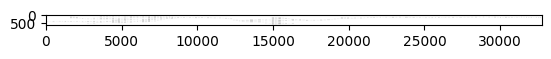

In [93]:
import onnx
onnx_model = onnx.load("model.v1.onnx")


from onnx.tools.net_drawer import GetOpNodeProducer, GetPydotGraph

pydot_graph = GetPydotGraph(
    onnx_model.graph, name=onnx_model.graph.name, rankdir="LR", node_producer=GetOpNodeProducer("docstring")
)
pydot_graph.write_dot("graph.dot")

import os
os.system("dot -O -Tsvg graph.dot")

import matplotlib.pyplot as plt

image = plt.imread("graph.dot.png")
plt.imshow(image)

[array([[-2.1201398,  2.5672958, -0.3095349]], dtype=float32)]

In [18]:
import pymorphy2
from dataset_builder import calculate_word_features_for_tokens, get_word_features, PAD_TOKEN
import onnxruntime as ort
import numpy as np

def torch_model_runner(model):
    model.eval()
    def func(input):
        with torch.no_grad():
            return model(input)
    return func

def onnx_model_runner(path):
    ort_sess = ort.InferenceSession(path)
    def func(input):
        return ort_sess.run(None, {'inputt': np.array(input) })[0]
    return func

def infer(model, text):
    assert params["RETAIN_LEFT_PUNCT"] # 

    unpadded_tokens = text.split(' ')
    unpadded_tokens = list(filter(lambda x: len(x) > 0, unpadded_tokens))
    tokens = [PAD_TOKEN] * params['INPUT_WORDS_CNT_LEFT'] + unpadded_tokens + [PAD_TOKEN] * (params["INPUT_WORDS_CNT_RIGHT"] + 1)
    features = calculate_word_features_for_tokens(tokens, params)

    res = ""

    i = params['INPUT_WORDS_CNT_LEFT']
    while i < len(tokens) - params['INPUT_WORDS_CNT_RIGHT']:
        tokens_for_batch = tokens[i - params['INPUT_WORDS_CNT_LEFT']: i + params['INPUT_WORDS_CNT_RIGHT']]

        tokens_for_batch_copy = tokens_for_batch.copy()
        tokens_for_batch_copy.insert(params['INPUT_WORDS_CNT_LEFT'], '?')
        # print(" ".join(tokens_for_batch_copy))


        features_for_batch = features[i - params['INPUT_WORDS_CNT_LEFT']: i + params['INPUT_WORDS_CNT_RIGHT']]
        features_for_batch = torch.stack((features_for_batch, ))
        output_probs = model(features_for_batch)
        punct_idx = np.argmax(output_probs).item()
        punct = params["ID_TO_PUNCTUATION"][punct_idx]

        # print(punct)

        # punct = '.'

        if punct != '$empty':
            res += punct
            if tokens[i] != 'PAD':
                res += " " + tokens[i]
            tokens.insert(i, punct)
            features = torch.cat((features[:i], 
                    torch.stack((get_word_features(punct, params), )), 
                    features[i:]), 0)
            i += 2
        else:
            if tokens[i] != 'PAD':
                res += " " + tokens[i]
            i += 1

    return res.strip()


infer(onnx_model_runner("model.v1.onnx"), "Отмечается что 44-летняя россиянка первый человек которому предъявят обвинение в попытке вмешаться в выборы 2018 года По информации Минюста она и еще несколько человек выдавала себя за американскую политическую активистку и скрывала свое российское происхождение")
# print(infer(torch_model_runner(model), "Я пришел домой Мама сварила суп"))
# https://onnxruntime.ai/docs/reference/ort-format-models.html

# infer(onnx_model_runner("model.v1.onnx"), "Я пришел домой Мама сварила суп")


'Отмечается, что 44-летняя россиянка, первый человек, которому предъявят обвинение в попытке вмешаться в выборы 2018 года. По информации Минюста, она и еще несколько человек выдавала себя за американскую политическую активистку и скрывала свое российское происхождение.'

In [49]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
morph.parse("фывфывфы")[0].inflect({'gent'})

Parse(word='фывфывфов', tag=OpencorporaTag('NOUN,inan,masc plur,gent'), normal_form='фывфывф', score=1.0, methods_stack=((FakeDictionary(), 'фывфывфов', 34, 7), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'фы')))

In [50]:
text = """
Кристина Герасимова (к концу десятилетия, кажется, поменявшая фамилию на Луна) к концу 2010-х оказалась одним из самых работоспособных музыкантов в русской поп-музыке (впрочем, и не только поп), выйдя на уровень, при котором она смогла себе позволить выпускать по альбому в год без потерь в качестве. Лучший из них, впрочем, «Заколдованные сны», как будто бы нарушал классическую для нее схему и уходил то в чистый и практически бессловесный электропоп, то в ностальгию по неприхотливой русской поп-музыке нулевых, то в постпанк — при этом всегда оставаясь песнями самой Луны.
"""
text = """

Мама, обычно холодная, как оконное стекло, была в такой ярости, что переколотила дома всю посуду. Хотела даже просить расчёт, но опомнилась: в других ресторанах и своих певиц хватало. Потому мама просто перестала брать Саню с собой, и он впервые оказался предоставлен самому себе. Поначалу Саня робел один выйти наружу, скучал, слонялся, не зная, чем заняться, — то по комнатам, то по двору. Но к весне осмелел настолько, что исследовал сперва окрестные улицы, а потом и весь обитаемый воронежский мир.

Мир этот оказался полон женщинами.

Саня, разинув от восхищения рот, смотрел на проплывающих по Большой Дворянской разодетых дам, похожих на вазы с фруктами и цветами. На гимназисток, вечно державшихся дрожащими стайками, словно мотыльки. На горничных девушек, спешащих по хозяйкиным делам и прошивающих город мелкими аккуратными стежками.

Саня влюбился во всех них сразу — и навсегда.""".replace("\n", " ")
print(text)

text = text.replace(".", "").replace(",", "").replace("\n", " ")
# text

  Мама, обычно холодная, как оконное стекло, была в такой ярости, что переколотила дома всю посуду. Хотела даже просить расчёт, но опомнилась: в других ресторанах и своих певиц хватало. Потому мама просто перестала брать Саню с собой, и он впервые оказался предоставлен самому себе. Поначалу Саня робел один выйти наружу, скучал, слонялся, не зная, чем заняться, — то по комнатам, то по двору. Но к весне осмелел настолько, что исследовал сперва окрестные улицы, а потом и весь обитаемый воронежский мир.  Мир этот оказался полон женщинами.  Саня, разинув от восхищения рот, смотрел на проплывающих по Большой Дворянской разодетых дам, похожих на вазы с фруктами и цветами. На гимназисток, вечно державшихся дрожащими стайками, словно мотыльки. На горничных девушек, спешащих по хозяйкиным делам и прошивающих город мелкими аккуратными стежками.  Саня влюбился во всех них сразу — и навсегда.


NameError: name 'model' is not defined

In [55]:
from time import time

start = time()
reps = 100
for i in range(0, reps):
    infer(onnx_model_runner("model.v1.onnx"), text)
end = time()

print(1 / ((end - start) / reps / len(text.split(' '))) / 8, 'tokens per second')



172.7963150459843 tokens per second


In [13]:
from time import time
dummy_input = torch.ones((1, params['INPUT_WORDS_CNT'], params['TOTAL_WORD_FEATURES_CNT']))
model.eval()

start = time()
reps = 10000
for i in range(0, reps):
    with torch.no_grad():
        model(dummy_input)
end = time()

print(1 / ((end - start) / reps) / 8, 'tokens per second')

129.86710276061967 tokens per second


In [14]:
from utils import count_parameters
count_parameters(model)

0.19739913940429688

In [3]:
import torch
model = torch.load("model.v1")
model

AttributeError: Can't get attribute 'Model' on <module '__main__'>